カルバック・ライブラー密度比推定の交差確認

2次元正規分布データを2セット用意して片方に異常値を挿入し、その異常値をカルバック・ライブラー密度比推定により検出する。

参考：
異常検知と変化検知　井出剛・杉山将著　P152

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dim = 100 #データの次元

mu = 0.01 #学習の乗数

num = 5 #データの分割数
train_dim = data_dim-int(data_dim/num)

#正規分布で2次元データを生成
data_x = np.random.normal(1, 1, data_dim*2)
data_y = np.random.normal(3, 0.5, data_dim*2)
data = np.c_[data_x, data_y]

#データを2分割し、片方に異常値を紛れ込ませる
normal_data = data[0:data_dim]
abnormal_data = data[data_dim:data_dim*2]
abnormal_data[data_dim-1] = [4, 5]

#RBF関数のバンド幅を複数用意する
num_w = 10
width = np.array([0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1, 1.3])

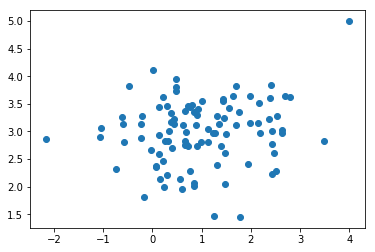

In [3]:
#異常値を含むデータのプロット
plt.scatter(abnormal_data[:, 0],abnormal_data[:, 1])

In [4]:
#RBF関数：x, yは同じ次元のベクトル、hはスカラー
def rbf(x,y,h): 
    return np.exp(-np.linalg.norm(x-y)**2/2/h**2)

In [5]:
#RBF関数を用いた確率密度比：xとy[b]は同じ次元のベクトル
def prob_ratio(theta,x,y,h): 
    out = 0
    for b in range(len(y)): 
        out += theta[b] * rbf(x,y[b],h)
    return out

In [6]:
#Closs validationのためデータを分割する。レコード数を2次元にして一つの行を抜いた後に1次元に戻す, rowsはdata数を割り切れる数字
def drop_row(data, rows, index): # data must be 1-dim array. rows must be larger than index
    shape = data.shape
    shape_rev1 = (rows, int(shape[0] / rows), shape[1])
    shape_rev2 = (shape[0] - int(shape[0] / rows), shape[1])
    drop_index = np.ones(rows,dtype=bool)
    drop_index[index] = False
    
    return data.reshape(shape_rev1)[drop_index].reshape(shape_rev2)

In [7]:
#確率密度比の評価関数（KL-Div）
def J_prob_ratio(theta, train, test, width):
    out = 0
    dim = len(train)

    for n in range(dim):
        out += prob_ratio(theta, test[n], train, width) / dim
        - np.log(prob_ratio(theta, train[n], train, width)) / dim
    
    return out

In [8]:
#勾配法によるThetaの更新・評価関数の最適化
def iterate_prob(theta, train, test, width, iter_num):
    dim = len(train)
    for t in range(iter_num):
        delta_j_a = np.zeros(dim)
        for b in range(dim):
            for n in range(dim):
                delta_j_a[b] +=  rbf(test[n], train[b], width)

        delta_j_b1 = np.zeros(dim)
        for b in range(dim):
            for n in range(dim):
                delta_j_b1[n] += rbf(train[n], train[b], width) * theta[b]

        delta_j_b2 = np.zeros(dim)
        for b in range(dim):
            for n in range(dim):
                delta_j_b2[b] += rbf(train[n], train[b], width) / delta_j_b1[n]

        delta_j = delta_j_a / dim - delta_j_b2 / dim

        theta = theta - mu * delta_j

        for b in range(dim):
            theta[b] = max(theta[b],0)
            
    return theta

In [9]:
#評価関数が最小になるようなRBF関数バンド幅の探索
iter_num = 50

J_ratio = np.zeros([num, num_w])

for h in range(num_w):
    theta = np.random.rand(num, train_dim)
    for k in range(num):
        train_data = drop_row(normal_data, num, k)
        test_data = drop_row(abnormal_data, num, k)

        theta[k] = iterate_prob(theta[k], train_data, test_data, width[h], iter_num)
        J_ratio[k, h] = J_prob_ratio(theta[k], train_data, test_data, width[h])
    
h = np.argmin(J_ratio.sum(axis=0))

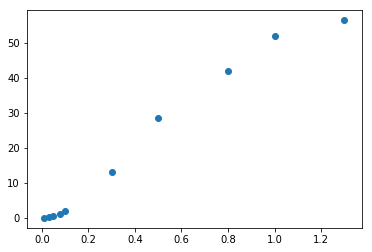

In [10]:
#バンド幅と評価関数の分布
plt.scatter(width, J_ratio.sum(axis=0))

In [11]:
#最適なバンド幅を用いて、データ全体で確率密度比の評価をする

h = 8 #width < 1 は結果が不安定になる

iter_num = 100

train_data = normal_data
test_data = abnormal_data

theta = np.random.rand(len(train_data))

theta = iterate_prob(theta, train_data, test_data, width[h], iter_num)

In [12]:
#学習済みのThetaを用いて異常値が含まれるデータについて、それぞれのレコードの確率密度比を算出する
test_data = abnormal_data
dim = len(train_data)
r = np.zeros(dim)
for n in range(dim):
    for b in range(dim):
        r[n] += rbf(test_data[n],train_data[b],width[h])*theta[b]

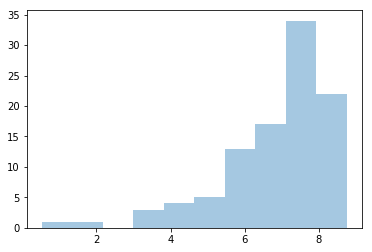

In [13]:
#確率密度比の分布
sns.distplot(r, kde=False, rug=False, bins=10)

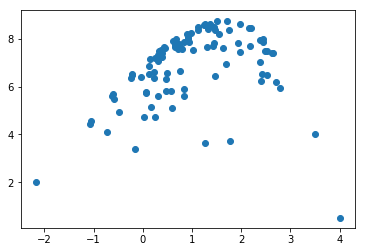

In [14]:
#データ（x軸）と確率密度比の分布
plt.scatter(test_data[:,0], r)

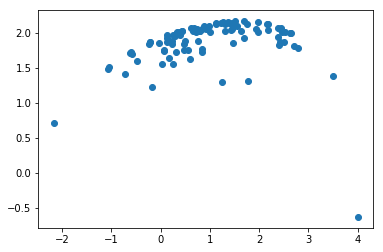

In [15]:
#データ（x軸）と確率密度比の対数の分布
#閾値を0.5とすれば、x=4のレコードが異常値と分類できる様子がわかる
plt.scatter(test_data[:,0], np.log(r))

In [16]:
r

array([6.48459938, 7.68075429, 7.78509907, 3.66398457, 6.3602072 ,
       7.92372134, 8.0211234 , 6.21674779, 7.49579521, 8.04046867,
       7.41907983, 8.60206866, 5.74235207, 7.49431132, 4.72123314,
       8.3585771 , 7.64582763, 8.34277113, 7.79333441, 8.4697997 ,
       7.21093961, 6.33921432, 8.50389726, 3.73945667, 5.58623471,
       8.75127005, 7.13752243, 7.02529116, 7.53030761, 5.77669276,
       5.61441983, 7.80662408, 5.61989872, 5.14694704, 7.87600757,
       6.3924362 , 5.09410936, 5.81345992, 8.6016059 , 2.03406025,
       7.96222424, 7.85815168, 7.60894835, 7.45094331, 8.38648273,
       7.06761193, 8.50988455, 7.59568129, 6.17010823, 7.82580404,
       7.41080436, 7.64630647, 3.40925392, 8.21711406, 7.55303259,
       8.42133272, 8.59160857, 7.89514903, 6.51221377, 6.60454715,
       4.11725991, 5.89680671, 6.55003378, 7.82566745, 7.63322044,
       7.38912199, 7.9758087 , 7.74952504, 5.66834411, 6.49023784,
       8.4596895 , 6.53480435, 5.48357859, 6.85802877, 7.53902